In [2412]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from prophet import Prophet


import datetime

from sklearn import set_config
set_config(display='diagram') 

plt.rcParams['figure.figsize'] = [20, 20]

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')


sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("poster")
sns.set_style("white")
palette = sns.color_palette("mako_r", 6)

# Helper functions

In [757]:
def import_data():
    # charging session data 
    
    df1 = pd.read_csv('data/Fort Collins Utilities EV Data June 2020 to June 2021.csv')
    
    df2 = pd.read_csv('data/Fort Collins Utilities EV Data June 25 2021 to July 20 2021.csv')
   
    df3 = pd.read_csv('data/FCU EV Charging Transaction Data July 20 2021 to Sept 2021.csv')
    
    
    weather_df = pd.read_csv('data/weather.csv')

    weather_df = (weather_df.assign(date=lambda x: pd.to_datetime(x['DATE']))
                            .set_index('date')
                 )

    return pd.concat([df1, df2, df3])

# Project description
**CONTEXT**:
For my capstone project at TDI, I took the initiative to personally reach out to the city of Fort Collins in Colorado because I was particularly interested in how small cities are managing their electric vehicle charging infrastructure during covid. I worked with them to build a data science solution to address their business problem.

Fort Collins received a support grant from the state but has to cover partial costs for maintenance. They wanted me to find out if they are making enough money from the stations to recover expenditures.

**ACTION**:
I built a solution to forecast the revenue generated from Electric Vehicle (EV) charging stations and forecast next months’ and next quarters’ usage.

**RESULT**:
Fort Collins paid upfront costs for the stations to cover a 5 year project. Based on forecasts, my web app provided information on when breakeven will be reached/when the stations will become profitable. It also provided pricing change recommendations in the event financial targets were not being reached on time.


In [758]:
df = import_data()

In [2472]:
df = (df.rename(columns={'Session/Reservation Start Date': 'Date'})
        .assign(date=lambda x: pd.to_datetime(x['Date']))
        .dropna(how='all')
        .set_index('date')
       
     )

# Do some cleaning

In [2473]:
df2 = (df[['Energy (kWh)', 'Net Revenue']]
       .resample('1D')
       .sum()
)

Apply a 7-day rolling average to smooth out some of the noisy fluctuations

In [2474]:
# 7-day rolling window
df2["Net Revenue_7D"] = df2['Net Revenue'].\
                         transform(lambda x: x.rolling('7D', closed='both', center=True).mean())

#df2['Net Revenue_7D'] = df2['Net Revenue_7D'].interpolate(method='linear', limit_direction='both')

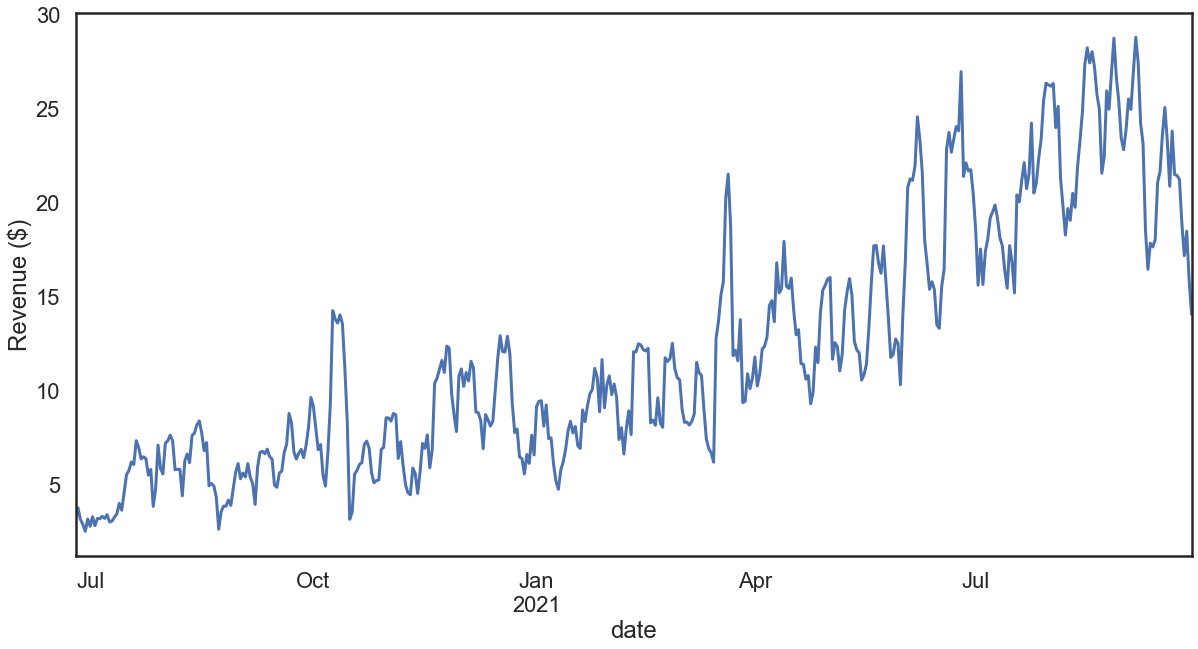

In [2475]:
df2["Net Revenue_7D"].plot()
plt.ylabel('Revenue ($)');

# For now, let's just focus on the revenue time series, ignoring other external factors such as dates of covid-related executive orders and weather. It is easy to add the dates of covid mandates (by categorical one-hot encoded variables) and also account for temperature and precipitation

Here I use a traditional ML approach, in particular, XGBoost, to forecast the next 30 days revenue collected from all the stations. I also compare to other algorithms such as Ridge, and Random Forest.

In [2476]:
import sys
sys.path.append('ml/')

### Test for stationarity
When modeling, there are assumptions that the summary statistics of observations are consistent. In time series terminology, we refer to this expectation as the time series being stationary.

These assumptions can be easily violated in time series by the addition of a trend, seasonality, and other time-dependent structures.

If a time series is non-stationary, summary statistics like the mean and variance change over time, providing a drift in the concepts a model attempts to capture. To make it easy for linear models to make predictions, we must remove any trend and seasonality.

To test for stationarity, we use the Dickey-Fuller test.
- Time series is not stationary according to ADF test: p > 0.05
- Then we will take the log of the time series and subtract a fitted trend over the entire time series.

In [2477]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df2['Net Revenue_7D'].ffill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.138391
p-value: 0.699522
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of Series.ffill will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [2478]:
# power transform
revenue_log = pd.DataFrame(df2["Net Revenue_7D"].apply(lambda x : np.log(x)))

# # Linear Trend
reg = LinearRegression().fit(np.arange(len(revenue_log)).reshape(-1, 1), revenue_log)
pred_lin = reg.predict(np.arange(len(revenue_log)).reshape(-1, 1))  

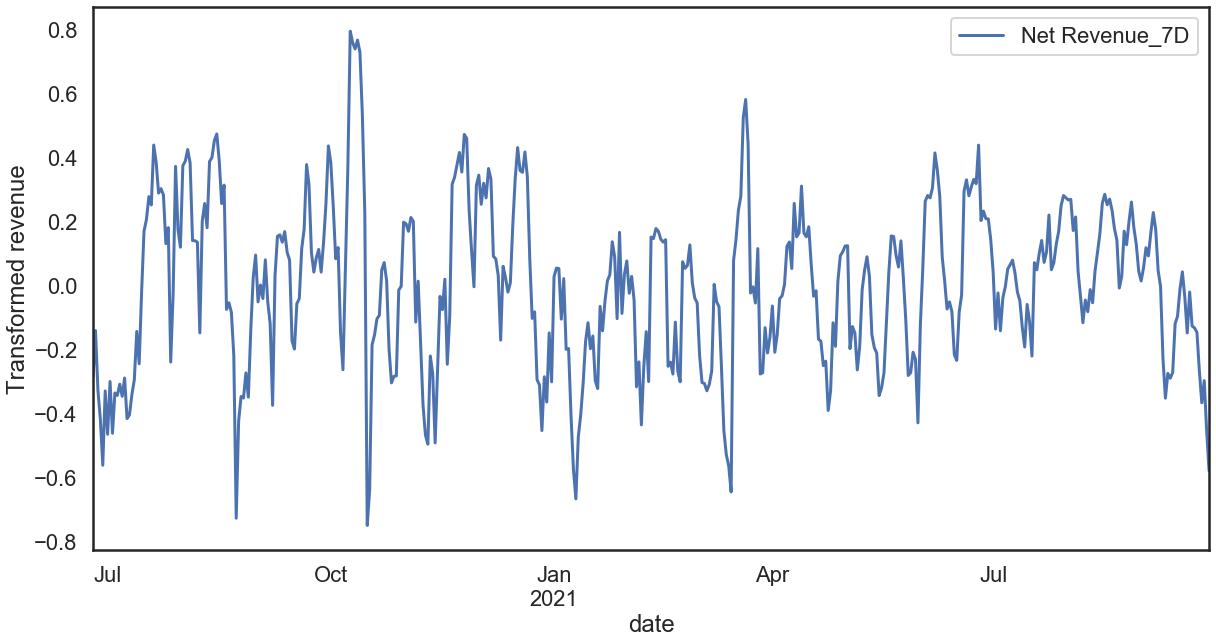

In [2479]:
log_diff = revenue_log - pred_lin
log_diff.plot()
plt.ylabel('Transformed revenue');

### This new series is now stationary (p < 0.05)
Note we did not have to difference to remove any seasonality to achieve stationarity. But i could also perform a differencing to remove any seasonality and reduce non-stationarity further

In [2480]:
result = adfuller(log_diff.bfill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.298955
p-value: 0.000446
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.bfill will be keyword-only
  """Entry point for launching an IPython kernel.


In [2481]:
df2['revenue_trans'] = log_diff

### Transform a time series dataset into a supervised learning dataset.
Each timepoint should have an associated 30 timepoints in the future

In [2492]:
def series_to_supervised(df, n_out):

    lags = np.arange(1, n_out+1, 1)
    for lag in lags:
        df['lag_'+ 'revenue' + str(lag)] = \
                    df['revenue_trans'].shift(-lag)
    return df.dropna(how='any')

In [2493]:
def train_test_split(data, n_test):
    return data.iloc[:-n_test, :], data.iloc[-n_test:, :]

### Train-test split
it will initially cover 07/31/21 to 09/28/21 but since we are only interested in time points where we have the next 30 days, we will reduce the test set to 08/29/21

In [2494]:
train, test = train_test_split(df2, 60)

X_train = series_to_supervised(train, 30)
X_test = series_to_supervised(test, 30)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [2495]:
y_train = X_train.loc[:, X_train.columns.str.startswith('lag')]
y_test = X_test.loc[:, X_test.columns.str.startswith('lag')]

# The actual model
The model makes use of SKlearn pipelines, custom transformers, column transformers and feature unions.

The custom transformers (classes) are defined in the ML folder. They engineer features from the data. As an example, there are transformers that fit fourier series of specified periods (daily, monthly, bi-annual, annual). There are also transformers that engineer date-tme features, for instance month of the year or is a weekend.

Right now i am just working with a single variable (univariate), but lets say i wanted to one-hot encode raining or not based on precipitation or one-hot encode covid-related dates, I could apply different transformations to specified fields of the data using column transformers. Regardless, I have set up the initial framework to make it clear how i could easily select different fields in the dataframe and apply transformations to them, thereby extending the framework to work with a multivariate problem.

Finally, the features are combined using a feature union and a model is built using a predictor and pipeline. This makes it easy to compare different algorithms because i can use the same pipeline but replace the type of algorithm (predictor) as the last step in the pipeline.

In [2496]:
from transformers import FourierTransformer, RollingMeanTransformer, TrendTransformer, DayofWeek, MonthofYear

In [2578]:
# i should perform a fourier transform of the time series first, to ascertain what periods are present in the
# signal. But for a proof of concept and based on initial EDA, i chose weekly, monthly and 6-month seasonalities.
fourier_feautres = ColumnTransformer(
    transformers=[
        ('fourier-w', FourierTransformer(period=7), ['revenue_trans']),
        ('fourier-1m', FourierTransformer(period=30), ['revenue_trans']),
        #('fourier-6m', FourierTransformer(period=6*30), ['revenue_trans']),
    ]
)

# this generates a 30-day rolling average as a feature
rolling_mean_trans = ColumnTransformer(
    transformers=[
       ('rolling-mean', RollingMeanTransformer(window=7), ['revenue_trans'])
    ]
)

# this is probably not needed since we removed the trend to make the series stationary.
trend_trans = ColumnTransformer(
    transformers=[
       ('trend', TrendTransformer(), ['revenue_trans'])
    ]
)

union = FeatureUnion([('fourier-components', fourier_feautres),
                      ('rolling_mean', rolling_mean_trans),
                      ('trend', trend_trans),
                      ('day_of_week', DayofWeek()),
                      ('month_of_year', MonthofYear()),
                      ('is_weekend', Weekend())
                      ])


# the transformation to make the time series stationary could be applied as part of the pipeline. However, i'm not
# sure at the moment how to subtract the trend. Also the problem becomes how to use the output of preprocessor as input
# to the other column transformers???
def detrend(x):
    logx = np.log(x) # log-transform
    
    reg = LinearRegression().fit(np.arange(len(x)).reshape(-1, 1), logx) # linear trend
    pred_lin = reg.predict(np.arange(len(x)).reshape(-1, 1))  
    
    return (logx - pred_lin)

preprocessor = ColumnTransformer(
    transformers=[
    ('log_trend_diff', FunctionTransformer(detrend, validate=False), ['Net Revenue_7D']),
], remainder='passthrough')
# also look into something called TransformedRegressor. You can specify the regressor, the transform function,
# and the inverse transform function





# compare different algorithms and show their MAPE performance on the test set against each other
# i chose these hyperparameters to inject some randomness and prevent overfitting to the training set.
#
pipe = Pipeline([('union', union),
                 ('lr', MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth=4, colsample_bytree=0.4,
                                                         subsample=0.4)))
                ])


pipe_ridge = Pipeline([('union', union),
                 ('sc', StandardScaler()),
                 ('lr', MultiOutputRegressor((Ridge())))
                ])

In [2579]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('fourier-components',
                                                 ColumnTransformer(transformers=[('fourier-w',
                                                                                  FourierTransformer(period=7),
                                                                                  ['revenue_trans']),
                                                                                 ('fourier-1m',
                                                                                  FourierTransformer(period=30),
                                                                                  ['revenue_trans'])])),
                                                ('rolling_mean',
                                                 ColumnTransformer(transformers=[('rolling-mean',
                                                                                  RollingMeanTransformer(window=7),
                                                                                  ['revenue_trans'...
                                                             importance_type='gain',
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None,
                                                             reg_alpha=None,
                                                             reg_lambda=None,
                                                             scale_pos_weight=None,
                                                             subsample=0.4,
                                                             tree_method=None,
                                                             validate_parameters=None,
                                                             verbosity=None)))])

## Make prediction on the test period. Scale predictions by applying inverse log transform to prediction with added linear trend

In [2580]:
predictions = pd.DataFrame(pipe.predict(X_test)[:, 0], index=X_test.index, columns=['revenue_trans'])
X_full = np.array(range(df2.shape[0]-X_test.shape[0], df2.shape[0]))
pred_lin = reg.predict(X_full.reshape(-1,1)) 

predictions_inv = predictions.transform(lambda x: np.exp(x + pred_lin[:, 0]))

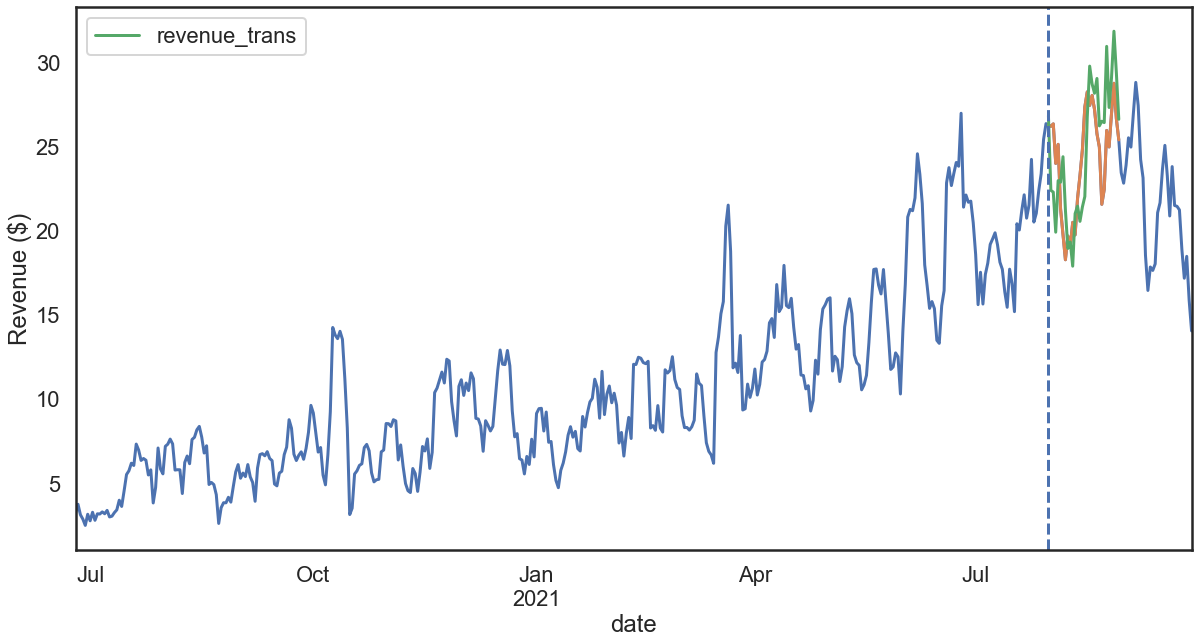

In [2581]:
fig, ax = plt.subplots()
df2["Net Revenue_7D"].plot(ax=ax)
X_test["Net Revenue_7D"].plot(ax=ax)
predictions_inv.plot(ax=ax)
plt.ylabel('Revenue ($)')
plt.axvline(x=datetime.datetime(2021, 7, 31), ls='--')

In [2582]:
test = np.exp(X_test[['lag_revenue1']]+pred_lin)
test = X_test['Net Revenue_7D']

y_pred = predictions_inv
mape = mean_absolute_percentage_error(y_pred, test)
f'The MAPE for the test period is {mape*100:.1f}%'

'The MAPE for the test period is 10.4%'

### 16% MAPE for the test set using XGBoost on differenced and log-transformed data and using fourier-components
We could possibly perform time series cross-validation to improve the generalization error on the test set.

In [2584]:
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score

# define a search space
space = {'n_estimators':hp.quniform('n_estimators', 100, 1000, 100),
           'max_depth':hp.quniform('max_depth', 4,10,1),
           'subsample':hp.quniform('subsample', 0.4, 0.9, 0.1),
           'colsample_bytree':hp.quniform('colsample_bytree', 0.4, 0.9, 0.1),
          }

# objective is to minimize mean-square error across CV folds
def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree']
             }
    
    xgb = XGBRegressor(**params)    

    #Pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', union),
        ('model', MultiOutputRegressor(xgb))
    ])
    
    tscv = TimeSeriesSplit(n_splits=5, max_train_size=90)
    score = cross_val_score(pipe, X_train, y_train, cv=tscv, 
                            scoring=make_scorer(mean_squared_error, multioutput='uniform_average'), 
                            n_jobs=-1).mean()

    return score

bestP = fmin(fn=objective, space=space, max_evals=5, rstate=np.random.RandomState(123), algo=tpe.suggest)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002898 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 20%|██        | 1/5 [00:47<03:08, 47.13s/trial, best loss: 0.11835111939663663]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004530 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.118351


 40%|████      | 2/5 [01:32<02:19, 46.56s/trial, best loss: 0.11491616143620562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002328 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.114916


 60%|██████    | 3/5 [02:35<01:43, 51.66s/trial, best loss: 0.11491616143620562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002639 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.114916


 80%|████████  | 4/5 [03:49<00:58, 58.17s/trial, best loss: 0.11491616143620562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002325 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.114916


100%|██████████| 5/5 [04:30<00:00, 54.19s/trial, best loss: 0.11491616143620562]


In [2585]:
model = XGBRegressor(
        n_estimators = int(bestP['n_estimators']),
        subsample = bestP['subsample'],
        colsample_bytree = bestP['colsample_bytree'],
        max_depth = int(bestP['max_depth'])
)

pipe = Pipeline(steps=[
        ('preprocessor', union),
        ('model', MultiOutputRegressor(model))
    ])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('fourier-components',
                                                 ColumnTransformer(transformers=[('fourier-w',
                                                                                  FourierTransformer(period=7),
                                                                                  ['revenue_trans']),
                                                                                 ('fourier-1m',
                                                                                  FourierTransformer(period=30),
                                                                                  ['revenue_trans'])])),
                                                ('rolling_mean',
                                                 ColumnTransformer(transformers=[('rolling-mean',
                                                                                  RollingMeanTransformer(window=7),
                                                                                  ['revenue...
                                                             importance_type='gain',
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=400,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None,
                                                             reg_alpha=None,
                                                             reg_lambda=None,
                                                             scale_pos_weight=None,
                                                             subsample=0.8,
                                                             tree_method=None,
                                                             validate_parameters=None,
                                                             verbosity=None)))])

In [2586]:
predictions = pd.DataFrame(pipe.predict(X_test)[:, 0], index=X_test.index, columns=['revenue_trans'])
X_full = np.array(range(df2.shape[0]-X_test.shape[0], df2.shape[0]))
pred_lin = reg.predict(X_full.reshape(-1,1)) 

predictions_inv = predictions.transform(lambda x: np.exp(x + pred_lin[:, 0]))

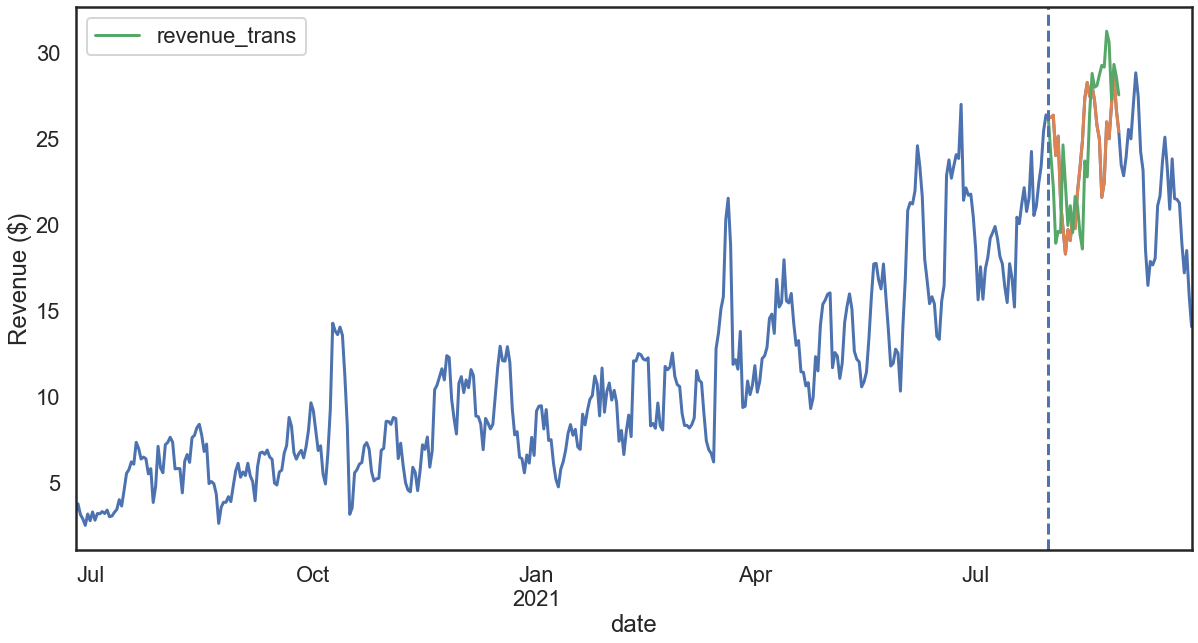

In [2587]:
fig, ax = plt.subplots()
df2["Net Revenue_7D"].plot(ax=ax)
X_test["Net Revenue_7D"].plot(ax=ax)
predictions_inv.plot(ax=ax)
plt.ylabel('Revenue ($)')
plt.axvline(x=datetime.datetime(2021, 7, 31), ls='--')

# Perform a walk-foward validation using SKlearn timeseries split
The function below performs walk-forward validation.

It takes the entire supervised learning version of the time series dataset and the number of rows to use as the test set as arguments.

It then steps through the test set, using the XGBoost model to make a one-step forecast (note that at each date we are predicting the next 30 days). An error measure is calculated and the details are returned for analysis.

In [2588]:
X = series_to_supervised(df2, 30)
y = X.loc[:, X.columns.str.startswith('lag')]
test = X.loc["2021-06-25":, X.columns.str.startswith('lag')]

### before comparing y_pred and y_actual, you need to perform inverse transforms on each

In [2589]:
def walk_forward_validation(df, test_start):
    
    X = series_to_supervised(df, 30)
    y = X.loc[:, X.columns.str.startswith('lag')]
    #test = X.loc["2021-06-25":, X.columns.str.startswith('lag')]
    test = X.loc[test_start:, X.columns.str.startswith('lag')]
    
    
    X_full = np.array(range(X.shape[0] - test.shape[0] + 1, X.shape[0]))
    pred_lin = reg.predict(X_full.reshape(-1,1)) 
    
    predictions = []

    # train a series of models on the prior 90 days to predict upto the next 30 days
    tscv = TimeSeriesSplit(n_splits=test.shape[0], max_train_size=90, test_size=1) 
    for train_index, test_index in tscv.split(X):

        print("Testing for: ", X.index[test_index[0]].strftime("%Y-%m-%d"))

        X_train, y_train = X.iloc[train_index], y.iloc[train_index]

        pipe.fit(X_train, y_train)

        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        y_hat = pipe.predict(X_test)

        #print("Actual = ", y_test.iloc[:, 0].values, ' : predicted = ', y_hat[0][0])

        predictions.append(y_hat)
    
    
    return predictions, test


In [2590]:
predictions, test = walk_forward_validation(df2, "2021-06-25")

Testing for:  2021-06-25
Testing for:  2021-06-26
Testing for:  2021-06-27
Testing for:  2021-06-28
Testing for:  2021-06-29
Testing for:  2021-06-30
Testing for:  2021-07-01
Testing for:  2021-07-02
Testing for:  2021-07-03
Testing for:  2021-07-04
Testing for:  2021-07-05
Testing for:  2021-07-06
Testing for:  2021-07-07
Testing for:  2021-07-08
Testing for:  2021-07-09
Testing for:  2021-07-10
Testing for:  2021-07-11
Testing for:  2021-07-12
Testing for:  2021-07-13
Testing for:  2021-07-14
Testing for:  2021-07-15
Testing for:  2021-07-16
Testing for:  2021-07-17
Testing for:  2021-07-18
Testing for:  2021-07-19
Testing for:  2021-07-20
Testing for:  2021-07-21
Testing for:  2021-07-22
Testing for:  2021-07-23
Testing for:  2021-07-24
Testing for:  2021-07-25
Testing for:  2021-07-26
Testing for:  2021-07-27
Testing for:  2021-07-28
Testing for:  2021-07-29
Testing for:  2021-07-30
Testing for:  2021-07-31
Testing for:  2021-08-01
Testing for:  2021-08-02
Testing for:  2021-08-03


In [2593]:

HORIZON = 30
eval_df = pd.DataFrame(np.squeeze(np.array(predictions)), columns =[(t) for t in range(1, 30+1)])

# inverse transform the predictions before evaluating forecasts   
eval_df_inv = eval_df.transform(lambda x: np.exp(x + pred_lin[:, 0]))
actual_df_inv = test.transform(lambda x: np.exp(x + pred_lin[:, 0]))

eval_df_inv['timestamp'] = test.index

eval_df_inv = pd.melt(eval_df_inv, id_vars='timestamp', value_name='prediction', var_name='h')

eval_df_inv['actual'] = np.array(np.transpose(actual_df_inv)).ravel()

#we characterize the forecast performance using the mean absolute percentage error
#The idea of this metric is to be sensitive to relative errors. 
# It is for example not changed by a global scaling of the target variable.

error = ( eval_df_inv.groupby('h').apply(lambda x: mean_absolute_percentage_error(x['actual'], x['prediction']))
                  .reset_index()
                  .sort_values(by='h')
                  .rename(columns={0:'Mean absolute percentage error (MAPE)'})
                  .set_index('h')
                 )

Text(0, 0.5, 'MAPE')

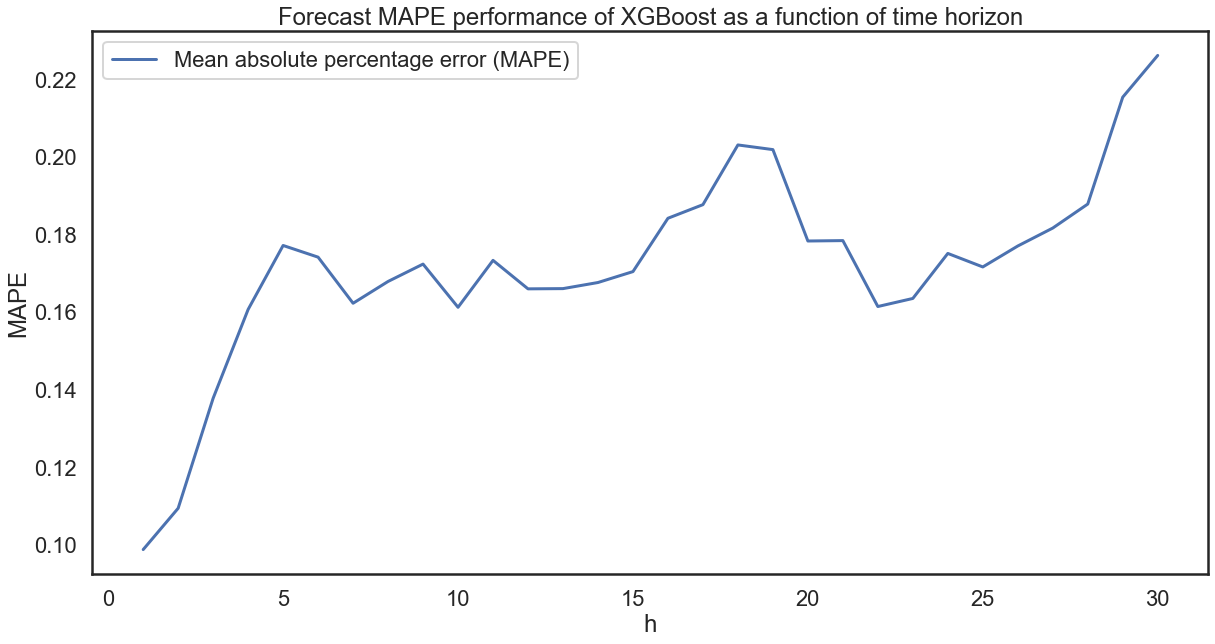

In [2594]:
#error['smoothed'] = error['Mean absolute percentage error (MAPE)'].transform(lambda x: x.rolling(3, min_periods=3, closed='both', center=True).mean())
error.plot()
plt.title('Forecast MAPE performance of XGBoost as a function of time horizon')
plt.ylabel('MAPE')

In [2595]:
error.mean()

Mean absolute percentage error (MAPE)    0.171935
dtype: float64

# Conclusions from walk-forward validation
This graph shows that on average that training a model using a 90 day rolling window across the entire data set, my 1-30 day forecasts have a MAPE of approx <= 20%


The walk-forward validation in combination with the SKlearn pipeline could form the basis of an analytics test bed to evaluate and compare the MAPE performance of forecasts with different time horizons. I am putting together high-level functions in order to compare ML algorithms, such as Ridge regression, Random forest, XGBoost, and lightGBM with more classical forecasting approaches such as SARIMAX. I will be adding SARIMAX to this notebook along with an assessment of performance with walk-forward validation.

# Meaning for the business objective
The business objective was two-fold:
- to understand if the stations are making any money
- use monthly and quarterly revenue forecasts to inform pricing decisions

### How does the forecasting solution deliver value?

This forecasting framework can be used to forecast the next quarter's revenue. The user can input a revenue target for the quarter and if the projected revenue does not meet the target by a specified, we can make recommendations to change the hourly rate for charging sessions. Currently, the hourly rate for charging is $0.90, but this value can be increased by a small amount in order for the projected revenue to reach the desired goal by the set date. 

This framework can easily be extended to forecast the next quarter and also take into account external factors like weather and covid threat levels. If revenue is lower than expected for a given quarter, the end user can examine feature importances before deciding that they want to change pricing. They might find that COVID cases have been particularly high recently or the weather was really cold and that they should hold off on playing with pricing and try to just monitor the situation. If these factors are not weighted heavily in the model, then the end-user can consider accepting an recommended increase in price.

# Lets try modeling with FBProphet
With Prophet, we don't have to care about stationarity. In Prophet, seasonalities are estimated using a partial Fourier sum.

In [2287]:
train = df2.loc[:'2021-07-10', 'Net Revenue_7D'].reset_index()
test = df2.loc['2021-07-10':, 'Net Revenue_7D'].reset_index()

In [2288]:
train = train.rename(columns={'date':'ds',
                      'Net Revenue_7D': 'y'})

In [2289]:

def is_stay_at_home(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.Timestamp(2020,3,25) and date < pd.Timestamp(2020,4,26))


def create_end_of_year_holidays_df():
    """Create holidays data frame for the end of the year season."""
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2019-12-25', '2020-12-25']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
    return holidays


def build_model():
    """Define forecasting model."""
    # Create holidays data frame. 
    holidays = create_end_of_year_holidays_df()
    
    model = Prophet(
        #yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=20
    )

#     model.add_seasonality(
#         name='stay_at_home', 
#         period=7, 
#         fourier_order=5, 
#         condition_name='is_stay_at_home'
#     )
#     model.add_seasonality(
#         name='no_stay_at_home', 
#         period=7, 
#         fourier_order=5, 
#         condition_name='is_not_stay_at_home')
    
    return model
    

In [2290]:
model = Prophet()
model = build_model()

In [2291]:
# train['is_stay_at_home'] = train['ds'].apply(is_stay_at_home)
# train['is_not_stay_at_home'] = ~train['ds'].apply(is_stay_at_home)

In [2292]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# generate predictions

In [2293]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=test.shape[0])
# future['is_stay_at_home'] = future['ds'].apply(is_stay_at_home)
# future['is_not_stay_at_home'] = ~future['ds'].apply(is_stay_at_home)
# Generate predictions. 
forecast = model.predict(df=future)

In [2294]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
457,2021-09-25,25.129386,20.230749,29.629586
458,2021-09-26,24.727785,19.551727,29.793905
459,2021-09-27,24.521293,19.478878,29.373463
460,2021-09-28,24.588672,19.503895,29.504564
461,2021-09-29,25.310316,20.781537,29.983085


In [2295]:
mask2 = forecast['ds'] <= "2021-07-10"

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

In [2296]:
from prophet.plot import add_changepoints_to_plot

[[<matplotlib.lines.Line2D at 0x7fa7324e3610>],

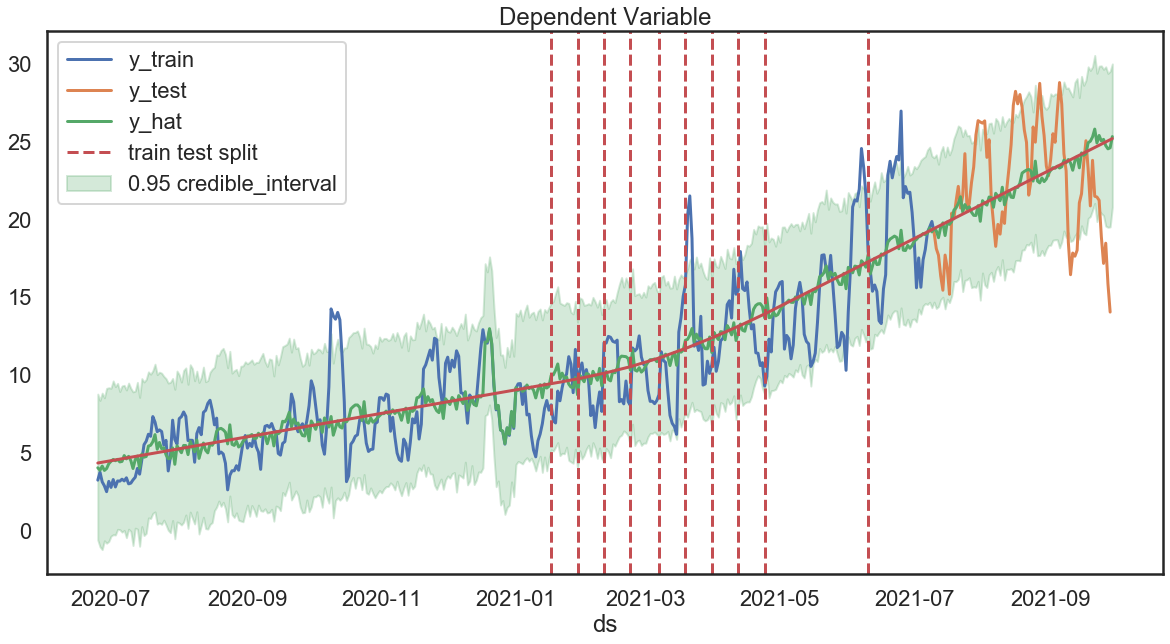

In [2297]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=train, ax=ax)
sns.lineplot(x='date', y='Net Revenue_7D', label='y_test', data=test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(datetime.datetime(2021,6,10), color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

    
add_changepoints_to_plot(ax, model, forecast)

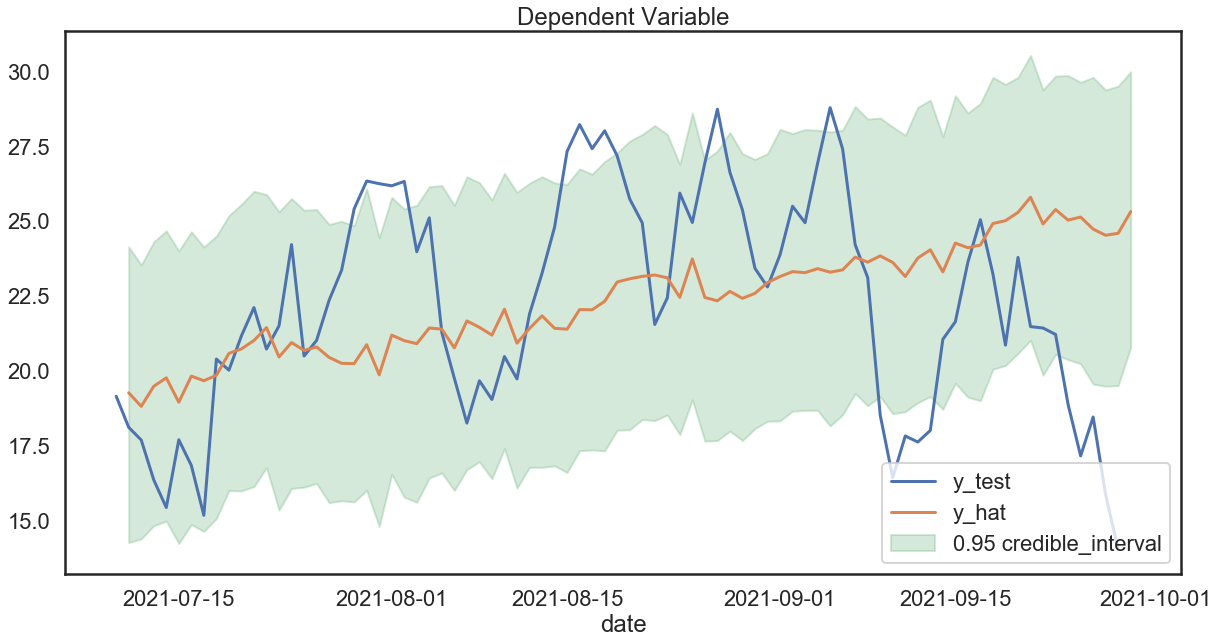

In [2298]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='date', y='Net Revenue_7D', label='y_test', data=test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

In [2299]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=test['Net Revenue_7D'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=test['Net Revenue_7D'], y_pred=forecast_test['yhat'])))

r2 train: 0.7480685664629106
r2 test: -0.11617821032601694
------------------------------
mape train: 0.21267333992256973
mape test: 0.14696759310279237


## FbProphet = 15% MAPE and XGBoost = 16% 
Not really that much of a difference but it's on a different interval. I imagine the differences would be more prominent in a multivariate forecasting problem. I really should compare the 30-day MAPE using walk-foward validation.

# Diagnostics - Time-slice Cross-Validation

In [2303]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(
    model=model, 
    initial='90 days', 
    period='30 days', 
    horizon = '30 days'
)

df_cv.head()

INFO:prophet:Making 9 forecasts with cutoffs between 2020-10-13 00:00:00 and 2021-06-10 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-10-14,8.822586,5.675413,11.520150,11.157143,2020-10-13
1,2020-10-15,9.980615,6.874838,13.091846,8.260000,2020-10-13
2,2020-10-16,9.638699,6.545397,12.558890,3.121429,2020-10-13
3,2020-10-17,8.881686,5.996315,11.837740,3.498571,2020-10-13
4,2020-10-18,10.260524,7.266748,13.579414,5.528571,2020-10-13


# As an MVP, I went with FBprophet for serving revenue projections in the web app because it achieves a slightly better overall MAPE than XGBoost (albeit with hand-tuned hyperparameters)

In [2312]:
df_p = performance_metrics(df=df_cv, rolling_window=0.1)


/opt/anaconda3/lib/python3.7/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.7/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


(0, 0.5)

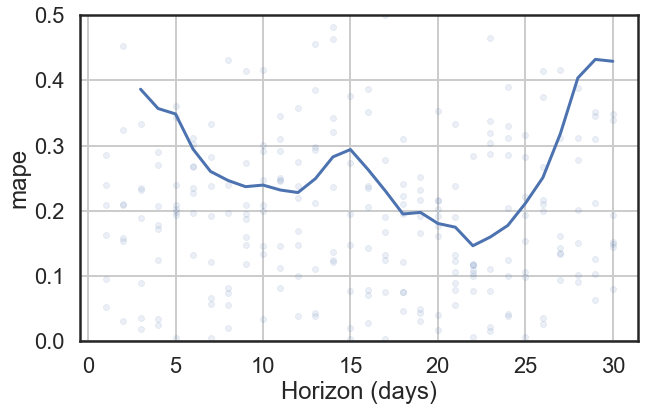

In [2311]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv=df_cv, metric='mape')
plt.ylim(0, 0.5)

# SARIMA model with pd-auto-arima for parameter tuning and walk-forward validation

auto-correlation and partial auto-correlation graphs were used to determine
possible values for the automatic lags for this model